In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,6

In [2]:
dataset = pd.read_csv("date.csv")
dataset['Date'] = pd.to_datetime(dataset['Date'], infer_datetime_format=True)
indexDataset = dataset.set_index(['Date'])

In [3]:
from datetime import datetime
indexDataset.head(5)

,AQI
Date,
2020-01-01,442
2020-01-02,441
2020-01-03,323
2020-01-04,348
2020-01-05,310


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


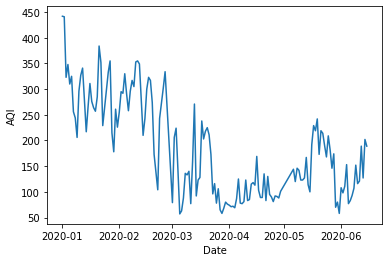

In [4]:
plt.xlabel("Date")
plt.ylabel("AQI")
plt.plot(indexDataset)

In [5]:
rolmean = indexDataset.rolling(window=24).mean()
rolstd = indexDataset.rolling(window=24).std()
print(rolmean,rolstd)

                   AQI
Date                  
2020-01-01         NaN
2020-01-02         NaN
2020-01-03         NaN
2020-01-04         NaN
2020-01-05         NaN
...                ...
2020-06-11  139.333333
2020-06-12  137.125000
2020-06-13  135.208333
2020-06-14  134.500000
2020-06-15  133.458333

[153 rows x 1 columns]                   AQI
Date                 
2020-01-01        NaN
2020-01-02        NaN
2020-01-03        NaN
2020-01-04        NaN
2020-01-05        NaN
...               ...
2020-06-11  53.087022
2020-06-12  49.619695
2020-06-13  49.058952
2020-06-14  47.905704
2020-06-15  46.348378

[153 rows x 1 columns]


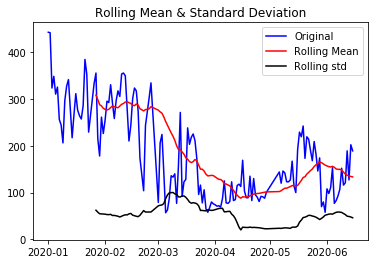

In [6]:
orig = plt.plot(indexDataset, color = 'blue', label='Original')
mean = plt.plot(rolmean, color = 'red', label='Rolling Mean')
std = plt.plot(rolstd, color = 'black', label = 'Rolling std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Standard Deviation')
plt. show(block = False)

In [7]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(indexDataset['AQI'], autolag = 'AIC')
dfout = pd.Series(dftest[0:4],index = ['Test Statistics','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfout['Critical Value (%s)'%key] = value
    
print(dfout)

Test Statistics                 -2.555470
p-value                          0.102554
#Lags Used                       3.000000
Number of Observations Used    149.000000
Critical Value (1%)             -3.475018
Critical Value (5%)             -2.881141
Critical Value (10%)            -2.577221
dtype: float64


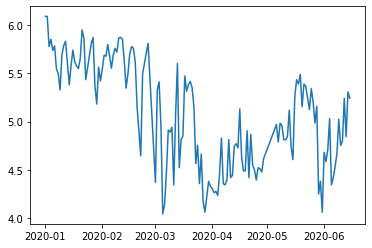

In [8]:
indexDataset_logScale = np.log(indexDataset)
plt.plot(indexDataset_logScale)

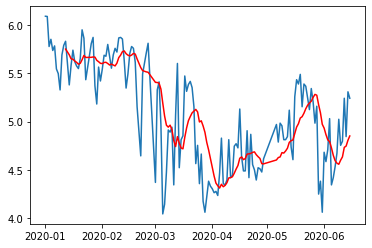

In [9]:
avg = indexDataset_logScale.rolling(window=12).mean()
std = indexDataset_logScale.rolling(window=12).std()
plt.plot(indexDataset_logScale)
plt.plot(avg,color='red')

In [10]:
datasetLogScaleMinusAvg = indexDataset_logScale - avg
datasetLogScaleMinusAvg.head(12)

datasetLogScaleMinusAvg.dropna(inplace = True)
datasetLogScaleMinusAvg.head(12)

,AQI
Date,
2020-01-12,0.080797
2020-01-14,-0.311904
2020-01-15,-0.066176
2020-01-16,0.093275
2020-01-17,-0.006800
2020-01-18,-0.037866
2020-01-19,-0.045177
2020-01-20,0.049293
2020-01-21,0.309657


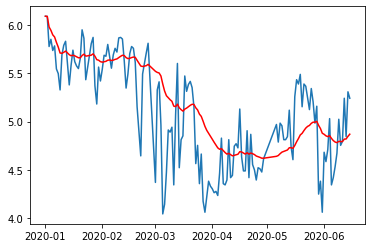

In [11]:
exponentialDecayWeightAvg = indexDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexDataset_logScale)
plt.plot(exponentialDecayWeightAvg, color='red')

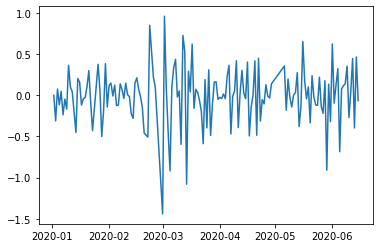

In [12]:
dataLogDiffShifting = indexDataset_logScale - indexDataset_logScale.shift()
plt.plot(dataLogDiffShifting)

In [13]:
dataLogDiffShifting.dropna(inplace=True)

In [14]:
indexDataset_logScale.shape

(153, 1)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


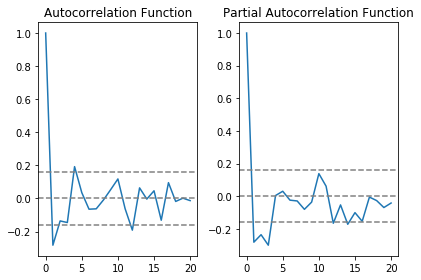

In [15]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(dataLogDiffShifting, nlags=20)
lag_pacf = pacf(dataLogDiffShifting, nlags=20, method='ols')

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(indexDataset_logScale)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(indexDataset_logScale)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(indexDataset_logScale)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(indexDataset_logScale)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


plotting AR Model


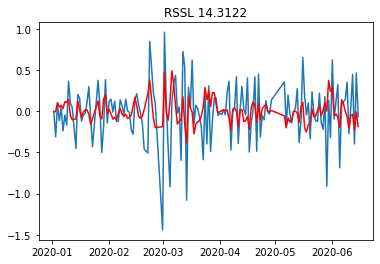

In [89]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(indexDataset_logScale, order=(1,1,2))
results_AR = model.fit(disp=-1)
plt.plot(dataLogDiffShifting)
plt.plot(results_AR.fittedvalues,color='red')
plt.title('RSSL %.4f'% sum((results_AR.fittedvalues-dataLogDiffShifting["AQI"])**2))
print("plotting AR Model")



In [90]:
predictions_AR = pd.Series(results_AR.fittedvalues, copy=True)
print(predictions_AR.head())

Date
2020-01-02   -0.005665
2020-01-03   -0.006669
2020-01-04    0.105181
2020-01-05    0.050096
2020-01-06    0.070860
dtype: float64


In [91]:
predictions_arima_diff_cummulative_sum = predictions_AR.cumsum()
print(predictions_arima_diff_cummulative_sum.head())

Date
2020-01-02   -0.005665
2020-01-03   -0.012334
2020-01-04    0.092847
2020-01-05    0.142943
2020-01-06    0.213803
dtype: float64


In [92]:
predictions_AR_Log = pd.Series(indexDataset_logScale['AQI'].ix[0],index=indexDataset_logScale.index)
predictions_AR_Log = predictions_AR_Log.add(predictions_arima_diff_cummulative_sum,fill_value=0)
predictions_AR_Log.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Date
2020-01-01    6.091310
2020-01-02    6.085645
2020-01-03    6.078976
2020-01-04    6.184157
2020-01-05    6.234253
dtype: float64

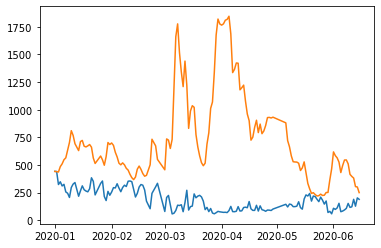

In [93]:
predictions_AR = (np.exp(predictions_AR_Log))
plt.plot(indexDataset)
plt.plot(predictions_AR)

In [94]:
indexDataset_logScale

,AQI
Date,
2020-01-01,6.091310
2020-01-02,6.089045
2020-01-03,5.777652
2020-01-04,5.852202
2020-01-05,5.736572
...,...
2020-06-11,4.795791
2020-06-12,5.241747
2020-06-13,4.844187


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


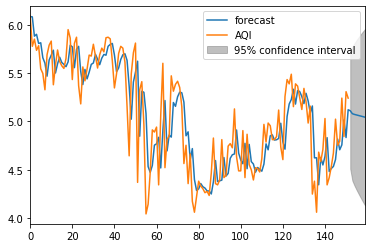

In [95]:
results_AR.plot_predict(1,160)
x =results_AR.forecast(steps=7)

In [97]:
len(x[0])
print(np.exp(x[0]))

[165.78010897 160.8279471  159.62733636 158.7041373  157.80608357
 156.91457186 156.02820433]


In [98]:
print(np.exp(x[1]))

[1.35900133 1.42412549 1.45593767 1.48493082 1.51296088 1.54026499
 1.56694561]


In [99]:
print(np.exp(x[2]))

[[ 90.87119763 302.43955453]
 [ 80.42896072 321.59595668]
 [ 76.44573958 333.31990316]
 [ 73.12236674 344.45005433]
 [ 70.09191582 355.28719282]
 [ 67.29502528 365.88414611]
 [ 64.70002498 376.27188787]]
